# TVB NEST

## Custom co-simulation with TVB and NEST on CSCS infrastructure

# ---------------------------------------------------------------------------------------------------------------

### In the cells which start with '%%writefile', the python code is not executed. We just store the code in a file and the execution will take place on CSCS servers.

In [1]:
filename = "cell_example.py"

In [2]:
%%writefile $filename

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

import matplotlib as mpl
mpl.use('Agg')

import os
import time
import numpy as np
from tvb_nest.config import Config
from tvb_nest.examples.example import main_example
from tvb_nest.nest_models.builders.models.red_ww_exc_io_inh_i import RedWWExcIOInhIBuilder
from tvb_nest.interfaces.builders.models.red_ww_exc_io_inh_i \
    import RedWWexcIOinhIBuilder as InterfaceRedWWexcIOinhIBuilder
from tvb_multiscale.plot.plotter import Plotter
from tvb_multiscale.simulator_tvb.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI
from tvb.datatypes.connectivity import Connectivity


config = Config(output_base="outputs/")
config.figures.SAVE_FLAG = False
config.figures.SHOW_FLAG = False
config.figures.MATPLOTLIB_BACKEND = "Agg"
plotter = Plotter(config)

# Select the regions for the fine scale modeling with NEST spiking networks
nest_nodes_inds = []  # the indices of fine scale regions modeled with NEST
# In this example, we model parahippocampal cortices (left and right) with NEST
connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
for id in range(connectivity.region_labels.shape[0]):
    if connectivity.region_labels[id].find("hippo") > 0:
        nest_nodes_inds.append(id)

tvb_sim_model = ReducedWongWangExcIOInhI()
nest_model_builder = RedWWExcIOInhIBuilder
tvb_nest_builder = InterfaceRedWWexcIOinhIBuilder
nest_population_order=100
simulation_length=100.0
tvb_state_variable_type_label="Synaptic Gating Variable"
delays=True
dt=0.1
noise_strength=0.001
exclusive_nodes=True

Overwriting cell_example.py


In [3]:
%%writefile -a $filename


# ----------------1. Load TVB connectivity----------------------------------------------------

connectivity.configure()
plotter.plot_tvb_connectivity(connectivity)
if not delays:
    connectivity.tract_lengths /= 100000.0
    connectivity.configure()
plotter.base.plot_regions2regions(connectivity.delays, connectivity.region_labels, 111, "Delays")
plotter.base._save_figure(figure_name="Delays")

Appending to cell_example.py


In [4]:
%%writefile -a $filename


from tvb_multiscale.simulator_tvb.simulator import Simulator
from tvb.simulator.monitors import Raw
# ----------------2. Define a TVB simulator (model, integrator, monitors...)--------------------

# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = Simulator()
simulator.integrator.dt = dt
simulator.integrator.noise.nsig = np.array([noise_strength])
simulator.model = tvb_sim_model

simulator.connectivity = connectivity
mon_raw = Raw(period=simulator.integrator.dt)
simulator.monitors = (mon_raw,)

Appending to cell_example.py


In [5]:
%%writefile -a $filename


# ----------------3. Build the NEST network model (fine-scale regions' nodes, stimulation devices, spike_detectors etc)-------

print("Building NEST network...")
tic = time.time()

# Build a NEST network model with the corresponding builder
# Using all default parameters for this example
nest_model_builder = nest_model_builder(simulator, nest_nodes_inds, config=config)
# Common order of neurons' number per population:
nest_model_builder.population_order = nest_population_order
nest_network = nest_model_builder.build_spiking_network()

print("Done! in %f min" % ((time.time() - tic) / 60))

Appending to cell_example.py


In [6]:
%%writefile -a $filename


# ----------------4. Build the TVB-NEST interface model -----------------------------------------

print("Building TVB-NEST interface...")
tic = time.time()
# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
# Using all default parameters for this example
tvb_nest_builder = tvb_nest_builder(simulator, nest_network, nest_nodes_inds, exclusive_nodes)
tvb_nest_model = tvb_nest_builder.build_interface()
print("Done! in %f min" % ((time.time() - tic)/60))

Appending to cell_example.py


In [7]:
%%writefile -a $filename


# ----------------5. Simulate and gather results-------------------------------------------------

# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_nest_model)
# ...and simulate!
t_start = time.time()
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - t_start))

Appending to cell_example.py


In [8]:
%%writefile -a $filename


# ----------------6. Plot results--------------------------------------------------------
from tvb_multiscale.examples.plot_results import plot_results
plot_results(results, simulator, tvb_state_variable_type_label, simulator.model.variables_of_interest, plotter)

Appending to cell_example.py


In [9]:
%%writefile -a $filename


# ----------------7. Save results--------------------------------------------------------
np.save(os.path.join(config.out.FOLDER_RES, "connectivity_weights.npy"), simulator.connectivity.weights)
np.save(os.path.join(config.out.FOLDER_RES, "connectivity_lengths.npy"), simulator.connectivity.tract_lengths)
np.save(os.path.join(config.out.FOLDER_RES, "results.npy"), results[0][1])

Appending to cell_example.py


In [10]:
!cat $filename


from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

import matplotlib as mpl
mpl.use('Agg')

import os
import time
import numpy as np
from tvb_nest.config import Config
from tvb_nest.examples.example import main_example
from tvb_nest.nest_models.builders.models.red_ww_exc_io_inh_i import RedWWExcIOInhIBuilder
from tvb_nest.interfaces.builders.models.red_ww_exc_io_inh_i \
    import RedWWexcIOinhIBuilder as InterfaceRedWWexcIOinhIBuilder
from tvb_multiscale.plot.plotter import Plotter
from tvb_multiscale.simulator_tvb.models.reduced_wong_wang_exc_io_inh_i import ReducedWongWangExcIOInhI
from tvb.datatypes.connectivity import Connectivity


config = Config(output_base="outputs/")
config.figures.SAVE_FLAG = False
config.figures.SHOW_FLAG = False
config.figures.MATPLOTLIB_BACKEND = "Agg"
plotter = Plotter(config)

# Select the regions for the fine scale modeling with NEST spiking networks
nest_nodes_inds = []  # the indices of fine scale regions mo

# ---------------------------------------------------------------------------------------------------------------

Configure UNICORE client

In [11]:
!pip install pyunicore --upgrade
import pyunicore.client as unicore_client

tr = unicore_client.Transport(oauth.get_token())
r = unicore_client.Registry(tr, unicore_client._HBP_REGISTRY_URL)

# use "DAINT-CSCS" -- change if another supercomputer is prepared for usage
site_client = r.site('DAINT-CSCS')
site_client.site_url

Requirement already up-to-date: pyunicore in /opt/conda/lib/python3.6/site-packages (0.5.7)


'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core'

Preparing job configuration

In [12]:
# We want to run the file which was computed above
script_to_run = filename
job_inputs = [script_to_run]

# Pass the job configuration file, where we specify that we want to pull and run the tvb-nest docker image
job_configuration = "job_config.sh"
job_config = {
    "From": "https://raw.githubusercontent.com/the-virtual-brain/tvb-multiscale/update-collab-examples/docker/cosimulate_with_staging.sh",
    "To" : job_configuration
}

# Build job configuration JSON
my_job = {}
my_job['Executable'] = job_configuration
my_job['Arguments'] = [script_to_run]
my_job['Imports'] = [job_config]
my_job['Resources'] = { "CPUs": "1" }
my_job

{'Arguments': ['cell_example.py'],
 'Executable': 'job_config.sh',
 'Imports': [{'From': 'https://raw.githubusercontent.com/the-virtual-brain/tvb-multiscale/update-collab-examples/docker/cosimulate_with_staging.sh',
   'To': 'job_config.sh'}],
 'Resources': {'CPUs': '1'}}

In [13]:
# Actual job submission
job = site_client.new_job(job_description=my_job, inputs=job_inputs)
job.properties

{'_links': {'action:abort': {'description': 'Abort',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/jobs/bdb2418e-0842-40aa-bbd5-fdb925bb1e32/actions/abort'},
  'action:restart': {'description': 'Restart',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/jobs/bdb2418e-0842-40aa-bbd5-fdb925bb1e32/actions/restart'},
  'action:start': {'description': 'Start',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/jobs/bdb2418e-0842-40aa-bbd5-fdb925bb1e32/actions/start'},
  'parentTSS': {'description': 'Parent TSS',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/sites/715f1b74-9ea5-4443-a293-b3514bc13673'},
  'self': {'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/jobs/bdb2418e-0842-40aa-bbd5-fdb925bb1e32'},
  'workingDirectory': {'description': 'Working directory',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/bdb2418e-0842-40aa-bbd5-fdb925bb1e32-uspace'}},
 'acl': [],
 'currentTime': '2020-02-18T

Wait until the job is complete

In [31]:
job.is_running()

False

In [30]:
job.properties['status']

'SUCCESSFUL'

In [32]:
wd = job.working_dir
wd.properties

{'_links': {'copy': {'description': "Copy file 'from' to file 'to'.",
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/bdb2418e-0842-40aa-bbd5-fdb925bb1e32-uspace/actions/copy'},
  'files': {'description': 'Files',
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/bdb2418e-0842-40aa-bbd5-fdb925bb1e32-uspace/files'},
  'rename': {'description': "Rename file 'from' to file 'to'.",
   'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/bdb2418e-0842-40aa-bbd5-fdb925bb1e32-uspace/actions/rename'},
  'self': {'href': 'https://brissago.cscs.ch:8080/DAINT-CSCS/rest/core/storages/bdb2418e-0842-40aa-bbd5-fdb925bb1e32-uspace'}},
 'acl': [],
 'currentTime': '2020-02-18T17:02:00+0100',
 'description': "Job's workspace",
 'metadataSupported': False,
 'mountPoint': '/scratch/snx3000/unicore/FILESPACE/bdb2418e-0842-40aa-bbd5-fdb925bb1e32/',
 'owner': 'CN=Valean Bogdan 308596,O=HBP',
 'protocols': ['BFT', 'SBYTEIO', 'UFTP', 'RBYTEIO'],
 're

In [33]:
wd.listdir()

{'.UNICORE_81a65937-59fc-480f-8b8b-8af574065e4c/': PathDir: .UNICORE_81a65937-59fc-480f-8b8b-8af574065e4c/,
 'UNICORE_Job_1582041530093': PathFile: UNICORE_Job_1582041530093,
 'UNICORE_SCRIPT_EXIT_CODE': PathFile: UNICORE_SCRIPT_EXIT_CODE,
 'bss_submit_1582041530093': PathFile: bss_submit_1582041530093,
 'cell_example.py': PathFile: cell_example.py,
 'job_config.sh': PathFile: job_config.sh,
 'outputs/': PathDir: outputs/,
 'stderr': PathFile: stderr,
 'stdout': PathFile: stdout}

Download results and plot them

In [34]:
wd.stat("outputs/res/results.npy").download("results.npy")
wd.stat("outputs/res/connectivity_weights.npy").download("connectivity_weights.npy")
wd.stat("outputs/res/connectivity_lengths.npy").download("connectivity_lengths.npy")

import numpy
result_ts = numpy.load("results.npy")
connectivity_weights = numpy.load("connectivity_weights.npy")
connectivity_lengths = numpy.load("connectivity_lengths.npy")

/opt/conda/lib/python3.6/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'y1': array([-20.,   2.]), 'z': array([ 2.,  5.]), 'x2': array([-2.,  0.]), 'y2': array([ 0.,  2.]), 'g': array([-1.,  1.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.epileptor.Epileptor2D.tt = NArray(label='tt', dtype=float64, default=array([ 1.]), dim_names=(), ndim=None, required=True)
WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.epileptor.Epileptor2D.state_variable_range = Final(field_type=<class 'dict'>, default={'x1': array([-2.,  1.]), 'z': array([ 2.,  5.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.ep

WARNING  Field seems mutable and has a default value. Consider using a lambda as a value factory 
   attribute tvb.simulator.models.stefanescu_jirsa.ReducedSetFitzHughNagumo.state_variable_range = Final(field_type=<class 'dict'>, default={'xi': array([-4.,  4.]), 'eta': array([-3.,  3.]), 'alpha': array([-4.,  4.]), 'beta': array([-3.,  3.])}, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.a = NArray(label=':math:`a`', dtype=float64, default=array([ 1.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 3.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHindmarshRose.b = NArray(label=':math:`b`', dtype=float64, default=array([ 3.]), dim_names=(), ndim=None, required=True)
WARNING  default contains values out of the declared domain. Ex 1.0 
   attribute  tvb.simulator.models.stefanescu_jirsa.ReducedSetHind

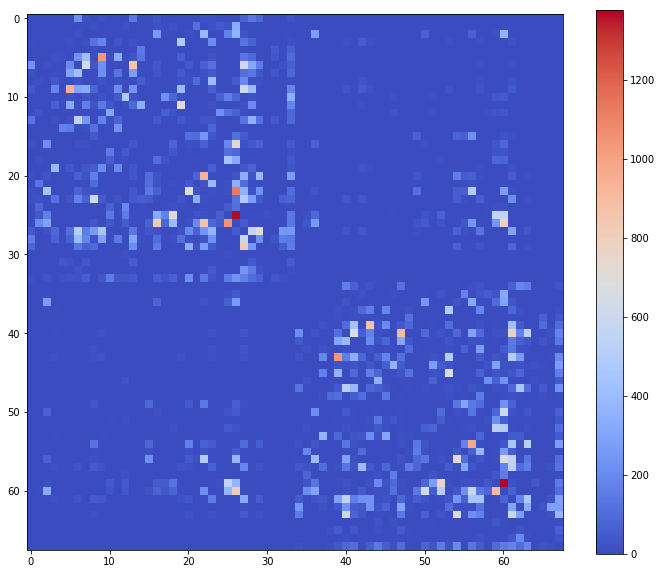

In [35]:
%matplotlib inline
from tvb.simulator.lab import *
from tvb.simulator.plot import tools

tools.plot_matrix(connectivity_weights)

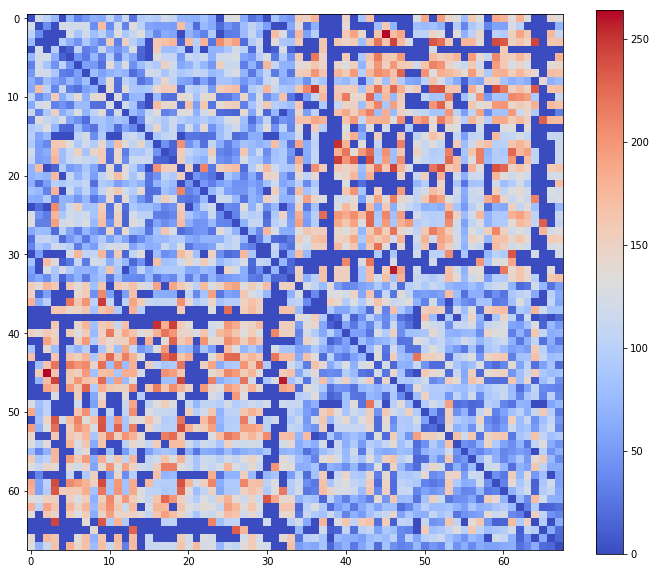

In [36]:
tools.plot_matrix(connectivity_lengths)

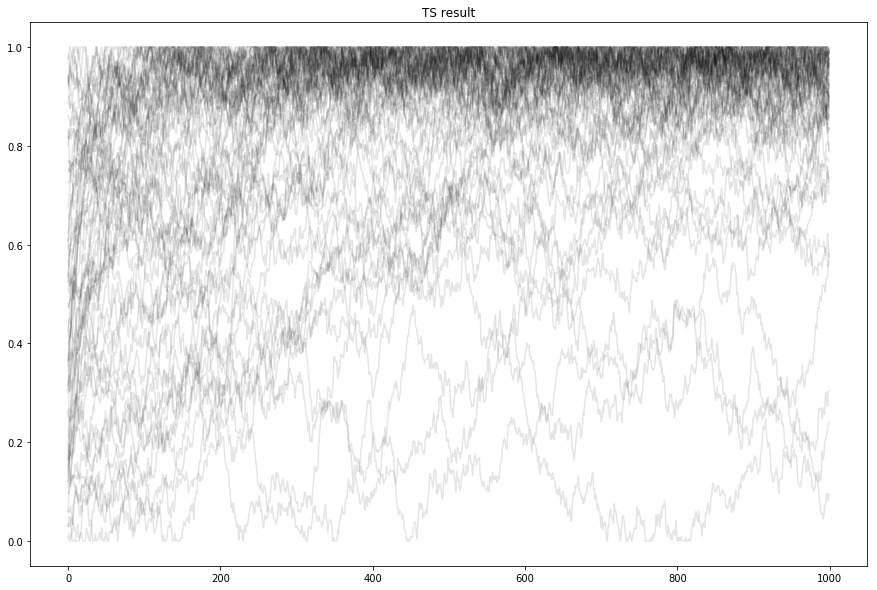

In [37]:
from matplotlib.pyplot import *
figure(figsize=(15, 10))
plot(numpy.arange(1000), result_ts[:, 0, :, 0], 'k', alpha=0.1)
title("TS result")